Canada International Assistance Projects Web Scraper

https://w05.international.gc.ca/projectbrowser-banqueprojets/filter-filtre

Part 1 - Scrape the Website

In [ ]:
%pip install selenium
%pip install requests
%pip install pandas numpy matplotlib seaborn
%pip install nltk gensim pandas scikit-learn
%pip install pyLDAvis
%pip install wordcloud

In [1]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.action_chains import ActionChains
from io import StringIO
from datetime import datetime
import requests
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction import _stop_words
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
from gensim import corpora
from gensim.models import Phrases, LdaModel
from gensim.models.phrases import Phraser
from wordcloud import WordCloud

In [15]:
# ----OPTIONAL: CHECK CHROME DRIVER IS SETUP CORRECTLY----
driver = webdriver.Chrome()
driver.get("https://w05.international.gc.ca/projectbrowser-banqueprojets/filter-filtre")

In [2]:
# ---- DATE RANGE TO USE ----
start_date = "01-01-2019"  # MM-DD-YYYY format

# ---- SETUP CHROME DRIVER ----
chrome_options = Options()
chrome_options.add_experimental_option("prefs", {
    "download.prompt_for_download": False,
    "profile.default_content_settings.popups": 0,
    "safebrowsing.enabled": True,
    "safebrowsing.disable_download_protection": False,
})

driver = webdriver.Chrome(options=chrome_options)
wait = WebDriverWait(driver, 15)
actions = ActionChains(driver)

# ---- OPEN TARGET PAGE ----
driver.get("https://w05.international.gc.ca/projectbrowser-banqueprojets/filter-filtre")

# ---- STEP 1: OPEN 'MORE FILTERS' ----
more_filters_summary = wait.until(EC.element_to_be_clickable((By.ID, "moreFilters")))
more_filters_summary.click()

# ---- STEP 2: INPUT START DATE ----
start_input = wait.until(EC.presence_of_element_located((By.ID, "StartDate")))

start_input.clear()
start_input.send_keys(start_date)

print(f"Entered start date: {start_date}")

# ---- STEP 3: CLICK 'APPLY FILTER' ----
apply_filter_btn = wait.until(EC.element_to_be_clickable((By.ID, "applyFilter")))
apply_filter_btn.click()
print("Filters applied.")

# ---- STEP 4: CLICK 'DOWNLOAD FILTERED PROJECTS' ----
download_button = wait.until(EC.element_to_be_clickable((By.ID, "wb-auto-4")))
download_button.click()
print("Clicked download button.")

# ---- STEP 5: SEND HTTP REQUEST TO GET DATA WITHOUT DOWNLOADING CSV FILE ----
cookies = driver.get_cookies()
session = requests.Session()
for cookie in cookies:
    session.cookies.set(cookie['name'], cookie['value'])

csv_url = "https://w05.international.gc.ca/projectbrowser-banqueprojets/filter-filtre/generate-c-s-v"

response = session.get(csv_url)
print(response.status_code)
print(response.text[:500])  # print first 500 chars to check content

# ---- STEP 6: CLOSE CHROME DRIVER ----
driver.quit()


Entered start date: 01-01-2019
Filters applied.
Clicked download button.
200
ï»¿Project Number,Date Modified,Title, Description,Status,Start Date,End Date,Country,Executing Agency Partner,DAC Sector,Maximum Contribution,Contributing Organization,Expected Results,Progress and Results Achieved,Aid Type,Collaboration Type,Finance Type,Flow Type,Reporting Organization,Program Name,Selection Mechanism,Policy Markers,Region,Alternate IM Position,Budget,Locations,Other Identifier
CA-3-D004760001,2025-06-12	,Amplifying Women's Voices for Sexual and Reproductive Health and Right


In [3]:
# ---- STEP 7: PROCESS DATA RECEIVED FROM HTTP REQUEST ----
# Convert text to file-like object
text = response.text.encode('latin1').decode('iso-8859-1')
text = text.encode('iso-8859-1', errors='replace').decode('utf-8')
csv_data = StringIO(text)
# Use csv.reader to correctly handle quoted fields
reader = csv.reader(csv_data)

# Extract header
header = next(reader)
fixed_cols_count = 25
fixed_cols_count = min(fixed_cols_count, len(header))

# Create fixed header
fixed_header = header[:fixed_cols_count] + ['CombinedRest']

# Process rows
fixed_rows = []
for row in reader:
    first_part = row[:fixed_cols_count]
    combined_rest = ','.join(row[fixed_cols_count:]) if len(row) > fixed_cols_count else ''
    new_row = first_part + [combined_rest]
    fixed_rows.append(new_row)

# Create DataFrame
df = pd.DataFrame(fixed_rows, columns=fixed_header)

# Clean column names
df.columns = (
    df.columns
    .str.strip()
    .str.replace('^\ufeff', '', regex=True)
    .str.replace('ï»¿', '')
)

df.head()

,Project Number,Date Modified,Title,Description,Status,Start Date,End Date,Country,Executing Agency Partner,DAC Sector,...,Finance Type,Flow Type,Reporting Organization,Program Name,Selection Mechanism,Policy Markers,Region,Alternate IM Position,Budget,CombinedRest
0,CA-3-D004760001,2025-06-12\t,Amplifying Women's Voices for Sexual and Repro...,This project aims to contribute to the empower...,Terminating,2019-01-09\t,2023-03-31\t,South Sudan: 100.00%,BBC Media Action,Population policy and administrative managemen...,...,Aid grant excluding debt reorganisation,,Global Affairs Canada,WGM Africa,Department-Initiated,2 - Gender equality; 0 - Environmental sustain...,,,Budget Type:Original;Start Date:2017-04-01;End...,"000"";Budget Type:Original;Start Date:2018-04-0..."
1,CA-3-D004529001,2025-06-12\t,Women's Voice and Leadership - Sri Lanka,This project is part of Canada’s Women’s Voice...,Closed,2019-01-21\t,2023-11-30\t,Sri Lanka: 100.00%,The Asia Foundation,Women's rights organisations and movements an...,...,Aid grant excluding debt reorganisation,,Global Affairs Canada,OGM Indo-Pacific,Department-Initiated,2 - Gender equality; 0 - Environmental sustain...,,,Budget Type:Original;Start Date:2018-04-01;End...,"000"";Budget Type:Original;Start Date:2019-04-0..."
2,CA-3-P006523001,2025-06-12\t,Women's Empowerment and Resilient Inclusive Co...,This project aims to promote community cohesio...,Closed,2019-01-29\t,2022-12-31\t,Myanmar: 100.00%,UNDP - United Nations Development Programme,Budget planning: 5.00%;Democratic participatio...,...,Aid grant excluding debt reorganisation,,Global Affairs Canada,OGM Indo-Pacific,Department-Initiated,1 - Gender equality; 0 - Environmental sustain...,,,Budget Type:Revised;Start Date:2018-04-01;End ...,"000,000"";Budget Type:Revised;Start Date:2019-0..."
3,CA-3-P006361001,2025-06-12\t,Environmental Rehabilitation and Improving Liv...,The project aims to secure a safe and healthy ...,Terminating,2019-02-01\t,2022-06-30\t,Bangladesh: 100.00%,UNDP - United Nations Development Programme,Vocational training: 44.00%;Energy conservatio...,...,Aid grant excluding debt reorganisation,,Global Affairs Canada,OGM Indo-Pacific,Department-Initiated,1 - Gender equality; 2 - Environmental sustain...,,,Budget Type:Original;Start Date:2018-04-01;End...,"000,000"";Budget Type:Original;Start Date:2019-..."
4,CA-3-P005384001,2025-06-12\t,Enabling Women's Potential in Peace Processes ...,The purpose of the initiative is to prepare wo...,Closed,2019-02-28\t,2019-08-31\t,"Chad: 18.00%,Burkina Faso: 18.00%,Niger: 18.00...",Université de Montréal - Service de l'admissio...,Women's rights organisations and movements an...,...,Aid grant excluding debt reorganisation,,Global Affairs Canada,YFMInternaAssistPartnershp&Programing Br,Foreign Affairs and Trade Gs&Cs,2 - Gender equality; 0 - Environmental sustain...,,,Budget Type:Original;Start Date:2018-04-01;End...,"506"""",Geoname Code:2287781;SRSName:http://www...."


Part 2 - Data Cleaning and Analysis

In [4]:
df['Start Date'] = pd.to_datetime(df['Start Date'], errors='coerce')
df['End Date'] = pd.to_datetime(df['End Date'], errors='coerce')
df['Year'] = df['Start Date'].dt.year
df = df.loc[:, ~((df.isna() | (df == '')).all())]
df['Maximum Contribution'] = df['Maximum Contribution'].replace({'\$': '', ',': ''}, regex=True)
df['Maximum Contribution'] = pd.to_numeric(df['Maximum Contribution'], errors='coerce')
df =df.drop(['CombinedRest'], axis=1, errors='ignore')

In [5]:
# For exporting data to Excel
excel_path = "canada_international_projects.xlsx"

Theme Identification

In [6]:
# Combine 'Description' and 'Expected Results' columns into a single column for analysis
texts = df['Description'].fillna('') + ' ' + df['Expected Results'].fillna('')

# Custom stopwords
custom_stopwords = set([
    'project', 'include', 'support', 'activities', 'expected', 'providing', 'humanitarian', 'assistance',
    'contributing', 'including', 'increased', 'cfli', 'outcomes', 'projects', 'needs', 'improved',
    'populations', 'people', 'organizations', 'countries', 'affected', 'small', 'international', 'local',
    'human', 'services', 'vulnerable', 'dignity', 'canada', 'aims', 'development', 'persons', 'access',
    'global', 'economic', 'national', 'canadian', 'implementation', 'states', 'capacity', 'acute',
    'outcome', 'million', 'developing', 'action', 'fund', 'united', 'nations', 'funding', '19', 'womenâ',
    'regional', 'priorities', 'red', 'initiatives', 'direct', 'advance', 'strengthen', 'situations',
    'community', 'communities', 'coordination', 'inclusive', 'policy', 'based', 'technical', 'lives',
    'strengthened', 'themes', 'offer', 'focusing', 'provide', 'closely', 'implemented', 'saved', 'ultimate',
    'suffering', 'alleviated', 'maintained', 'experiencing'
])


# Combine the default English stopwords with custom list:
english_stopwords = _stop_words.ENGLISH_STOP_WORDS  # set of default english stopwords
all_stopwords = list(english_stopwords.union(custom_stopwords))

vectorizer = CountVectorizer(
    max_df=0.85, 
    min_df=5, 
    stop_words=all_stopwords
)

Theme Identification Via Natural Language Processing (NLP)

In [7]:
# Topic Identification without bigrams
dtm = vectorizer.fit_transform(texts)

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(dtm)

# Function to print topics
def print_topics(model, feature_names, n_top_words):
    for idx, topic in enumerate(model.components_):
        print(f"Topic {idx}:")
        print([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])

print_topics(lda, vectorizer.get_feature_names_out(),3)

Topic 0:
['health', 'girls', 'women']
Topic 1:
['women', 'gender', 'rights']
Topic 2:
['health', 'food', 'protection']
Topic 3:
['education', 'gender', 'women']
Topic 4:
['rights', 'women', 'peace']


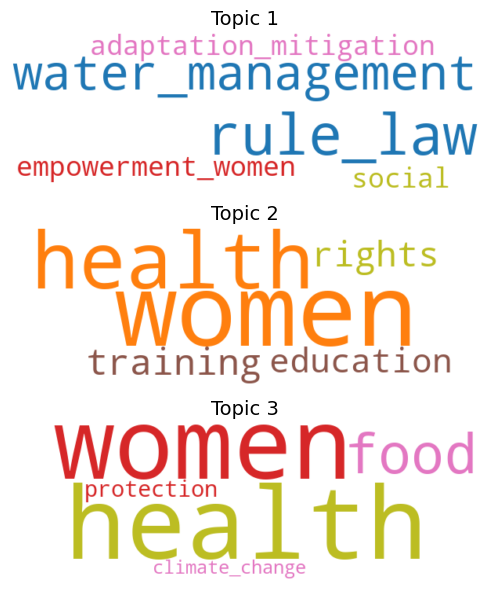

In [8]:
# Topic identification with bigrams
# Text preprocessing function
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    tokens = [token for token in tokens if token not in all_stopwords and len(token) > 2]
    return tokens

# Tokenize texts
tokenized_texts = [preprocess(doc) for doc in texts]

# Build bigrams
bigram_model = Phrases(tokenized_texts, min_count=5, threshold=10)
bigram_phraser = Phraser(bigram_model)
texts_with_bigrams = [bigram_phraser[doc] for doc in tokenized_texts]

# Create dictionary and corpus for LDA
dictionary = corpora.Dictionary(texts_with_bigrams)
dictionary.filter_extremes(no_below=5, no_above=0.75)
corpus = [dictionary.doc2bow(text) for text in texts_with_bigrams]

# Train LDA model with 3 topics
num_topics = 3
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    random_state=42,
    passes=10,
    alpha='auto',
    per_word_topics=True
)

# Define figure size in inches for a roughly square layout
fig_width = 6
fig_height = 6

# Each word cloud will have height = fig_height / num_topics
wc_width = int(fig_width * 100)   # 100 dpi
wc_height = int((fig_height / num_topics) * 100)

plt.figure(figsize=(fig_width, fig_height))

for topic_id in range(num_topics):
    plt.subplot(num_topics, 1, topic_id + 1)
    words_probs = dict(lda_model.show_topic(topic_id, topn=5))
    wc = WordCloud(
        width=wc_width,
        height=wc_height,
        background_color='white',
        colormap='tab10',
        prefer_horizontal=0.9,
        min_font_size=15,
    ).generate_from_frequencies(words_probs)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Topic {topic_id + 1}", fontsize=14)

plt.tight_layout()
plt.show()

In [9]:
# Export Topics Words and Weights to Excel for PowerBI
topic_words = []
num_words = 5  # Adjust based on your needs

for topic_id in range(num_topics):
    words_probs = lda_model.show_topic(topic_id, topn=num_words)
    for word, prob in words_probs:
        topic_words.append({"Topic": topic_id + 1, "Word": word, "Probability": prob})

# Convert to DataFrame
wc = pd.DataFrame(topic_words)

sheet_name = "Topic_WordCloud"

wc.to_excel(excel_path, sheet_name=sheet_name, index=False)

print(f"Data successfully saved to {sheet_name} in {excel_path}")


Data successfully saved to Topic_WordCloud in canada_international_projects.xlsx


Identifying Themes Via Keyword Frequency

In [10]:
X = vectorizer.fit_transform(texts)

# Convert to readable DataFrame
X_array = X.toarray()
vocab = vectorizer.get_feature_names_out()
bow_df = pd.DataFrame(X_array, columns=vocab)

# View output
print("Bag of Words Matrix:\n", bow_df.head())

Bag of Words Matrix:
    000  001  01  050  10  100  108  10m  10th  11  ...  youth  youths  zambia  \
0    0    0   0    0   0    0    0    0     0   0  ...      0       0       0   
1    0    0   0    0   0    0    0    0     0   0  ...      0       0       0   
2    0    0   0    0   0    0    0    0     0   0  ...      0       0       0   
3    0    0   0    0   0    0    0    0     0   0  ...      0       0       0   
4    0    0   0    0   0    0    0    0     0   0  ...      0       0       0   

   zanzibar  zero  zimbabwe  zone  zones  zoonotic  éducation  
0         0     0         0     0      0         0          0  
1         0     0         0     0      0         0          0  
2         0     0         0     0      0         0          0  
3         0     0         0     0      0         0          0  
4         0     0         0     0      0         0          0  

[5 rows x 3945 columns]


In [11]:
# Sum each word's count across all rows
word_counts = bow_df.sum(axis=0)

# Sort words by frequency (descending)
top_words = word_counts.sort_values(ascending=False)

print("Top words:")
print(top_words.head(20))

Top words:
women         8055
gender        4829
health        4113
girls         3830
rights        3173
food          1930
training      1705
climate       1662
security      1620
conflict      1571
education     1560
peace         1534
equality      1518
sexual        1462
social        1388
violence      1386
protection    1303
management    1156
water         1130
children      1082
dtype: int64


In [12]:
# Determine the most important words using TF-IDF
# Create a TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words=all_stopwords)
tfidf_matrix = tfidf_vectorizer.fit_transform(texts)

# Convert to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# To get overall importance of each word across the corpus, sum TF-IDF scores across all documents
word_importance = tfidf_df.sum(axis=0).sort_values(ascending=False)

print("Top Themes by TF-IDF:")
print(word_importance.head(10))

Top Themes by TF-IDF:
women       200.602017
rights      136.529969
health      130.663472
gender      122.463516
girls       122.364588
peace       105.925675
security     78.911095
food         78.321666
conflict     72.664709
equality     71.710343
dtype: float64


Identifying Themes Via Policy Marker (column in data)

In [13]:
# # Function to convert policy marker string into a dict of all policies with their values
# def policy_marker_to_dict(policy_str):
#     entries = [entry.strip() for entry in policy_str.split(';') if entry.strip()]
#     policy_dict = {}
#     for entry in entries:
#         try:
#             value, issue = entry.split(' - ', 1)
#             policy_dict[issue.strip()] = int(value.strip())
#         except ValueError:
#             continue
#     return policy_dict

# # Apply function to each row
# df['Policy Dict'] = df['Policy Markers'].apply(policy_marker_to_dict)

# # Convert list of dicts into a DataFrame
# policy_df = pd.json_normalize(df['Policy Dict'])

# # Combine with the original DataFrame
# df = pd.concat([df.drop(columns='Policy Dict'), policy_df], axis=1)

# # Fill missing policy values with 0
# df = df.fillna(0).astype({col: 'int' for col in policy_df.columns})

# # View final DataFrame
# print(df.iloc[0])


In [14]:
# # Count how many projects have each policy marker marked, regardless of importance
# policy_counts = (policy_df > 0).sum().sort_values(ascending=False)

# print("Number of times each policy marker was marked:")
# print(policy_counts)

In [15]:
# # Group by Year and count how many projects per year marked each policy
# policy_counts_over_time = df.groupby('Year')[policy_df.columns].apply(lambda x: (x > 0).sum())

# # Plot stacked bar chart
# policy_counts_over_time.plot(kind='bar', stacked=True, figsize=(14,7))

# plt.title('Number of Projects by Policy Marker Over Time')
# plt.xlabel('Year')
# plt.ylabel('Number of Projects')
# plt.legend(title='Policy Markers', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()
# plt.show()

In [16]:
# total_projects_per_year = df.groupby('Year').size()

# policy_percentage_over_time = policy_counts_over_time.divide(total_projects_per_year, axis=0) * 100

# plt.figure(figsize=(14, 7))

# for col in policy_percentage_over_time.columns:
#     plt.plot(policy_percentage_over_time.index, policy_percentage_over_time[col], marker='o', label=col)

# plt.title('Policy Markers as Percentage of Total Funded Projects Per Year')
# plt.xlabel('Year')
# plt.ylabel('Percentage of Projects (%)')
# plt.legend(title='Policy Markers', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

Identifying Themes via DAC Sector (column in data)

In [17]:
# Function to extract DAC Sectors from string (removes extra spaces)
def extract_sectors(sector_str):
    if pd.isna(sector_str):
        return []
    # Split by semicolons, then split each part by colon and take the first (sector name),
    # stripping extra spaces and capitalizing correctly
    parts = [part.split(':')[0].strip().title().replace("  ", " ") for part in sector_str.split(';') if ':' in part]
    return parts

# Apply to the column
df['Sector List'] = df['DAC Sector'].apply(extract_sectors)

# Example
print(df[['DAC Sector', 'Sector List']].head())

                                          DAC Sector  \
0  Population policy and administrative managemen...   
1  Women's rights organisations and movements  an...   
2  Budget planning: 5.00%;Democratic participatio...   
3  Vocational training: 44.00%;Energy conservatio...   
4  Women's rights organisations and movements  an...   

                                         Sector List  
0  [Population Policy And Administrative Manageme...  
1  [Women'S Rights Organisations And Movements An...  
2  [Budget Planning, Democratic Participation And...  
3  [Vocational Training, Energy Conservation And ...  
4  [Women'S Rights Organisations And Movements An...  


In [18]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
one_hot = pd.DataFrame(mlb.fit_transform(df['Sector List']),
                       columns=mlb.classes_,
                       index=df.index)
sector_cols = list(mlb.classes_)
df = pd.concat([df, one_hot], axis=1)
df['Sector Percentage'] = df['DAC Sector']
df = df.drop(columns=['DAC Sector'])
df.rename(columns={"Women'S Rights Organisations And Movements And Government Institutions": "Women's Rights Organisations And Movements And Government Institutions"}, inplace=True)
sector_cols = [col if col != "Women'S Rights Organisations And Movements And Government Institutions" 
               else "Women's Rights Organisations And Movements And Government Institutions" 
               for col in sector_cols]
df.head()

,Project Number,Date Modified,Title,Description,Status,Start Date,End Date,Country,Executing Agency Partner,Maximum Contribution,...,Urban Development And Management,Urban Land Policy And Management,Vocational Training,Waste Management/Disposal,Water Resources Conservation (Including Data Collection),Water Sector Policy And Administrative Management,Water Supply - Large Systems,Wind Energy,Women's Rights Organisations And Movements And Government Institutions,Sector Percentage
0,CA-3-D004760001,2025-06-12\t,Amplifying Women's Voices for Sexual and Repro...,This project aims to contribute to the empower...,Terminating,2019-01-09,2023-03-31,South Sudan: 100.00%,BBC Media Action,4998632,...,0,0,0,0,0,0,0,0,0,Population policy and administrative managemen...
1,CA-3-D004529001,2025-06-12\t,Women's Voice and Leadership - Sri Lanka,This project is part of Canada’s Women’s Voice...,Closed,2019-01-21,2023-11-30,Sri Lanka: 100.00%,The Asia Foundation,2829165,...,0,0,0,0,0,0,0,0,1,Women's rights organisations and movements an...
2,CA-3-P006523001,2025-06-12\t,Women's Empowerment and Resilient Inclusive Co...,This project aims to promote community cohesio...,Closed,2019-01-29,2022-12-31,Myanmar: 100.00%,UNDP - United Nations Development Programme,14000000,...,0,0,0,0,0,0,0,0,0,Budget planning: 5.00%;Democratic participatio...
3,CA-3-P006361001,2025-06-12\t,Environmental Rehabilitation and Improving Liv...,The project aims to secure a safe and healthy ...,Terminating,2019-02-01,2022-06-30,Bangladesh: 100.00%,UNDP - United Nations Development Programme,20000000,...,0,0,1,0,0,0,0,0,0,Vocational training: 44.00%;Energy conservatio...
4,CA-3-P005384001,2025-06-12\t,Enabling Women's Potential in Peace Processes ...,The purpose of the initiative is to prepare wo...,Closed,2019-02-28,2019-08-31,"Chad: 18.00%,Burkina Faso: 18.00%,Niger: 18.00...",Université de Montréal - Service de l'admissio...,919131,...,0,0,0,0,0,0,0,0,1,Women's rights organisations and movements an...


In [19]:
# Top DAC Sectors

# Flatten the list of sectros across all rows
all_sectors = [sector for sublist in df['Sector List'] for sector in sublist]

# Count each sector
sector_counts = Counter(all_sectors)

# Convert to a DataFrame for easier handling/sorting
sectors_counts_df = pd.DataFrame.from_dict(sector_counts, orient='index', columns=['Count'])
sectors_counts_df = sectors_counts_df.sort_values(by='Count', ascending=False)

# Display top N countries
print(sectors_counts_df)

                                                    Count
Material Relief Assistance And Services               390
Women'S Rights Organisations And Movements And ...    358
Multisector Aid                                       347
Ending Violence Against Women And Girls               256
Protection And Support Services                       241
...                                                   ...
Privatization                                           1
Energy Generation Non-Renewable Sources - Unspe...      1
Education And Training In Transport And Storage         1
Energy Regulation                                       1
District Heating And Cooling                            1

[213 rows x 1 columns]


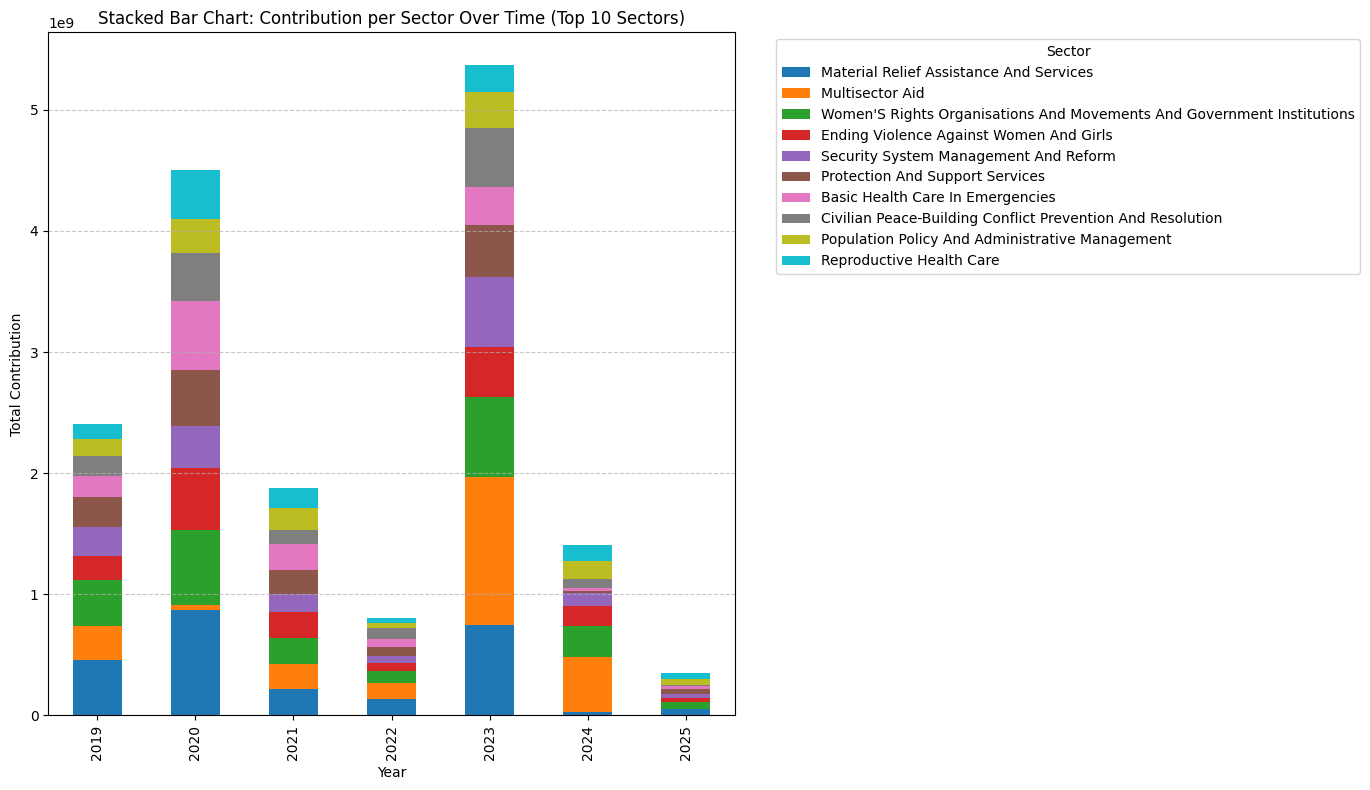

In [20]:
df_exploded = df.explode('Sector List').rename(columns={'Sector List': 'Sector Name'})
df_exploded['Maximum Contribution'] = df_exploded.groupby('Year')['Maximum Contribution'].transform('first')

# Step 2: Group by year and sector name
contribution_per_sector = df_exploded.groupby(['Year', 'Sector Name'])['Maximum Contribution'].sum().reset_index()


# Step 3: Pivot to get years as index and sector as columns
pivot_df = contribution_per_sector.pivot(index='Year', columns='Sector Name', values='Maximum Contribution').fillna(0)

# Optional: Filter top N countries for readability
top_sector = pivot_df.sum().sort_values(ascending=False).head(10).index
pivot_df_top = pivot_df[top_sector]

# Step 4: Plot
pivot_df_top.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='tab10')

# Formatting
plt.title('Stacked Bar Chart: Contribution per Sector Over Time (Top 10 Sectors)')
plt.xlabel('Year')
plt.ylabel('Total Contribution')
plt.legend(title='Sector', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Identifying Top Countries

In [21]:
# Function to extract country names from string
def extract_countries(country_str):
    if pd.isna(country_str):
        return []
    # Split by commas, then split each part by colon and take the first (country name)
    parts = [part.split(':')[0].strip() for part in country_str.split(',') if ':' in part]
    return parts

# Apply to the column
df['Countries List'] = df['Country'].apply(extract_countries)

# Example
print(df[['Country', 'Countries List']].head())

                                             Country  \
0                               South Sudan: 100.00%   
1                                 Sri Lanka: 100.00%   
2                                   Myanmar: 100.00%   
3                                Bangladesh: 100.00%   
4  Chad: 18.00%,Burkina Faso: 18.00%,Niger: 18.00...   

                                      Countries List  
0                                      [South Sudan]  
1                                        [Sri Lanka]  
2                                          [Myanmar]  
3                                       [Bangladesh]  
4  [Chad, Burkina Faso, Niger, Côte d'Ivoire, Mau...  


In [22]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
one_hot = pd.DataFrame(mlb.fit_transform(df['Countries List']),
                       columns=mlb.classes_,
                       index=df.index)
country_cols = list(mlb.classes_)
df = pd.concat([df, one_hot], axis=1)
df['Country Percentage'] = df['Country']
df = df.drop(columns=['Country'])
df.head()

,Project Number,Date Modified,Title,Description,Status,Start Date,End Date,Executing Agency Partner,Maximum Contribution,Expected Results,...,Uzbekistan,Vanuatu,Venezuela,Vietnam,Virgin Islands (British),West Bank Gaza,Yemen,Zambia,Zimbabwe,Country Percentage
0,CA-3-D004760001,2025-06-12\t,Amplifying Women's Voices for Sexual and Repro...,This project aims to contribute to the empower...,Terminating,2019-01-09,2023-03-31,BBC Media Action,4998632,The expected outcomes for this project include...,...,0,0,0,0,0,0,0,0,0,South Sudan: 100.00%
1,CA-3-D004529001,2025-06-12\t,Women's Voice and Leadership - Sri Lanka,This project is part of Canada’s Women’s Voice...,Closed,2019-01-21,2023-11-30,The Asia Foundation,2829165,The expected outcomes for this project include...,...,0,0,0,0,0,0,0,0,0,Sri Lanka: 100.00%
2,CA-3-P006523001,2025-06-12\t,Women's Empowerment and Resilient Inclusive Co...,This project aims to promote community cohesio...,Closed,2019-01-29,2022-12-31,UNDP - United Nations Development Programme,14000000,The expected results for this project include:...,...,0,0,0,0,0,0,0,0,0,Myanmar: 100.00%
3,CA-3-P006361001,2025-06-12\t,Environmental Rehabilitation and Improving Liv...,The project aims to secure a safe and healthy ...,Terminating,2019-02-01,2022-06-30,UNDP - United Nations Development Programme,20000000,The expected outcomes for this project include...,...,0,0,0,0,0,0,0,0,0,Bangladesh: 100.00%
4,CA-3-P005384001,2025-06-12\t,Enabling Women's Potential in Peace Processes ...,The purpose of the initiative is to prepare wo...,Closed,2019-02-28,2019-08-31,Université de Montréal - Service de l'admissio...,919131,The project’s expected results are as follows:...,...,0,0,0,0,0,0,0,0,0,"Chad: 18.00%,Burkina Faso: 18.00%,Niger: 18.00..."


In [23]:
# Top Countries Invested In

# Flatten the list of countries across all rows
all_countries = [country for sublist in df['Countries List'] for country in sublist]

# Count each country
country_counts = Counter(all_countries)

# Convert to a DataFrame for easier handling/sorting
country_counts_df = pd.DataFrame.from_dict(country_counts, orient='index', columns=['Count'])
country_counts_df = country_counts_df.sort_values(by='Count', ascending=False)

# Display top N countries
print(country_counts_df.head(10))

                     Count
Ukraine                156
Ethiopia               153
Democratic Republic    124
Bangladesh             120
Colombia               117
Burkina Faso           115
South Sudan            114
Nigeria                105
Mali                   104
Haiti                   96


In [24]:
# df_exploded = df.explode('Countries List').rename(columns={'Countries List': 'Country Name'})

# # Step 2: Group by year and country name
# projects_per_country_year = df_exploded.groupby(['Year', 'Country Name']).size().reset_index(name='Project Count')

# # Step 3: Pivot to get years as index and countries as columns
# pivot_df = projects_per_country_year.pivot(index='Year', columns='Country Name', values='Project Count').fillna(0)

# # Optional: Filter top N countries for readability
# top_countries = pivot_df.sum().sort_values(ascending=False).head(10).index
# pivot_df_top = pivot_df[top_countries]

# # Step 4: Plot
# pivot_df_top.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='tab10')

# # Formatting
# plt.title('Stacked Bar Chart: Number of Projects per Country Over Time (Top 10 Countries)')
# plt.xlabel('Year')
# plt.ylabel('Number of Projects')
# plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()

In [25]:
# total_per_year = projects_per_country_year.groupby('Year')['Project Count'].transform('sum')
# projects_per_country_year['Percentage'] = projects_per_country_year['Project Count'] / total_per_year * 100

# # Step 4: Pivot so each country becomes a column
# pivot_df = projects_per_country_year.pivot(index='Year', columns='Country Name', values='Percentage').fillna(0)

# # Optional: filter to top countries overall
# top_countries = pivot_df.sum().sort_values(ascending=False).head(10).index
# pivot_df_top = pivot_df[top_countries]

# # Step 5: Plot
# plt.figure(figsize=(14, 7))
# for country in pivot_df_top.columns:
#     plt.plot(pivot_df_top.index, pivot_df_top[country], marker='o', label=country)

# plt.title('Country Share of Projects per Year (%)')
# plt.xlabel('Year')
# plt.ylabel('Percentage of Projects')
# plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

Identifying Top Regions

In [26]:
# Function to extract Region from string
def extract_regions(region_str):
    if pd.isna(region_str):
        return []
    # Split by commas, then split each part by colon and take the first (country name)
    parts = [part.split(':')[0].strip().title() for part in region_str.split(';') if ':' in part]
    return parts

# Apply to the column
df['Region List'] = df['Region'].apply(extract_regions)

# Example
print(df[['Region', 'Region List']].head())

  Region Region List
0                 []
1                 []
2                 []
3                 []
4                 []


In [27]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
one_hot = pd.DataFrame(mlb.fit_transform(df['Region List']),
                       columns=mlb.classes_,
                       index=df.index)
region_cols = list(mlb.classes_)
df = pd.concat([df, one_hot], axis=1)
df['Region Percentage'] = df['Region']
df = df.drop(columns=['Region'])
df.head()

,Project Number,Date Modified,Title,Description,Status,Start Date,End Date,Executing Agency Partner,Maximum Contribution,Expected Results,...,Middle East Regional,North And Central America Regional,North Of Sahara Regional,Oceania Regional,South America Regional,South And Central Asia Regional,South Asia Regional,South Of Sahara Regional,West Indies Regional,Region Percentage
0,CA-3-D004760001,2025-06-12\t,Amplifying Women's Voices for Sexual and Repro...,This project aims to contribute to the empower...,Terminating,2019-01-09,2023-03-31,BBC Media Action,4998632,The expected outcomes for this project include...,...,0,0,0,0,0,0,0,0,0,
1,CA-3-D004529001,2025-06-12\t,Women's Voice and Leadership - Sri Lanka,This project is part of Canada’s Women’s Voice...,Closed,2019-01-21,2023-11-30,The Asia Foundation,2829165,The expected outcomes for this project include...,...,0,0,0,0,0,0,0,0,0,
2,CA-3-P006523001,2025-06-12\t,Women's Empowerment and Resilient Inclusive Co...,This project aims to promote community cohesio...,Closed,2019-01-29,2022-12-31,UNDP - United Nations Development Programme,14000000,The expected results for this project include:...,...,0,0,0,0,0,0,0,0,0,
3,CA-3-P006361001,2025-06-12\t,Environmental Rehabilitation and Improving Liv...,The project aims to secure a safe and healthy ...,Terminating,2019-02-01,2022-06-30,UNDP - United Nations Development Programme,20000000,The expected outcomes for this project include...,...,0,0,0,0,0,0,0,0,0,
4,CA-3-P005384001,2025-06-12\t,Enabling Women's Potential in Peace Processes ...,The purpose of the initiative is to prepare wo...,Closed,2019-02-28,2019-08-31,Université de Montréal - Service de l'admissio...,919131,The project’s expected results are as follows:...,...,0,0,0,0,0,0,0,0,0,


In [28]:
# Top Regions Sectors

# Flatten the list of regions across all rows
all_regions = [region for sublist in df['Region List'] for region in sublist]

# Count each region
region_counts = Counter(all_regions)

# Convert to a DataFrame for easier handling/sorting
regions_counts_df = pd.DataFrame.from_dict(region_counts, orient='index', columns=['Count'])
regions_counts_df = regions_counts_df.sort_values(by='Count', ascending=False)

# Display top N countries
print(regions_counts_df)

                                     Count
Africa  Regional                       511
Asia  Regional                         461
America  Regional                      410
Europe  Regional                       308
Oceania  Regional                      243
Developing Countries  Unspecified       95
South America  Regional                 80
Middle East  Regional                   78
South Of Sahara  Regional               78
North And Central America  Regional     60
West Indies  Regional                   58
Far East Asia  Regional                 51
South And Central Asia  Regional        17
North Of Sahara  Regional               14
South Asia  Regional                    11
Central Asia  Regional                   5


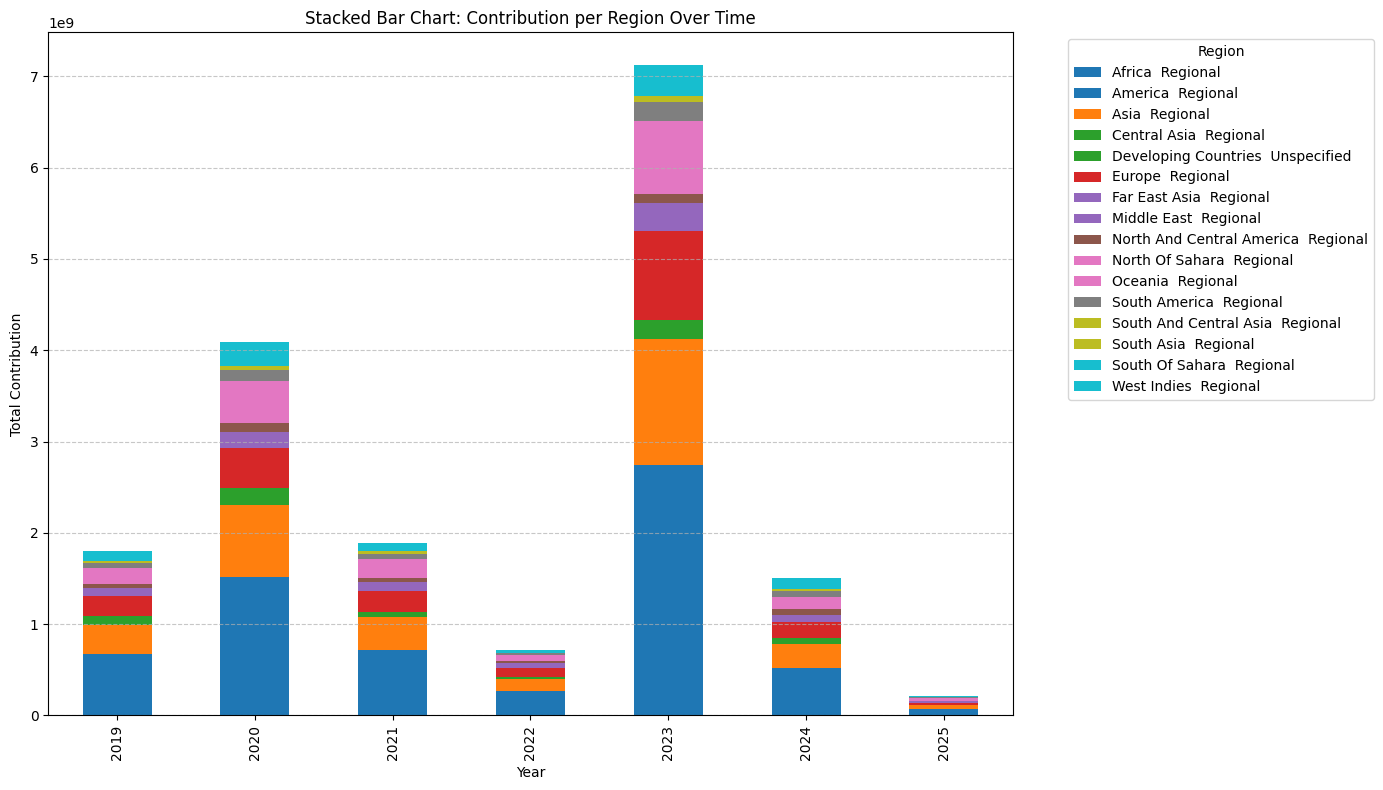

In [29]:
df_exploded = df.explode('Region List').rename(columns={'Region List': 'Region Name'})
df_exploded['Maximum Contribution'] = df_exploded.groupby('Year')['Maximum Contribution'].transform('first')

# Step 2: Group by year and region name
contribution_per_region = df_exploded.groupby(['Year', 'Region Name'])['Maximum Contribution'].sum().reset_index()


# Step 3: Pivot to get years as index and region as columns
pivot_df = contribution_per_region.pivot(index='Year', columns='Region Name', values='Maximum Contribution').fillna(0)

# Step 4: Plot
pivot_df.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='tab10')

# Formatting
plt.title('Stacked Bar Chart: Contribution per Region Over Time')
plt.xlabel('Year')
plt.ylabel('Total Contribution')
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Export Data

In [30]:
df.columns

Index(['Project Number', 'Date Modified', 'Title', 'Description', 'Status',
       'Start Date', 'End Date', 'Executing Agency Partner',
       'Maximum Contribution', 'Expected Results',
       ...
       'Middle East  Regional', 'North And Central America  Regional',
       'North Of Sahara  Regional', 'Oceania  Regional',
       'South America  Regional', 'South And Central Asia  Regional',
       'South Asia  Regional', 'South Of Sahara  Regional',
       'West Indies  Regional', 'Region Percentage'],
      dtype='object', length=436)

In [31]:
df.shape

(2897, 436)

In [32]:
df.head()

,Project Number,Date Modified,Title,Description,Status,Start Date,End Date,Executing Agency Partner,Maximum Contribution,Expected Results,...,Middle East Regional,North And Central America Regional,North Of Sahara Regional,Oceania Regional,South America Regional,South And Central Asia Regional,South Asia Regional,South Of Sahara Regional,West Indies Regional,Region Percentage
0,CA-3-D004760001,2025-06-12\t,Amplifying Women's Voices for Sexual and Repro...,This project aims to contribute to the empower...,Terminating,2019-01-09,2023-03-31,BBC Media Action,4998632,The expected outcomes for this project include...,...,0,0,0,0,0,0,0,0,0,
1,CA-3-D004529001,2025-06-12\t,Women's Voice and Leadership - Sri Lanka,This project is part of Canada’s Women’s Voice...,Closed,2019-01-21,2023-11-30,The Asia Foundation,2829165,The expected outcomes for this project include...,...,0,0,0,0,0,0,0,0,0,
2,CA-3-P006523001,2025-06-12\t,Women's Empowerment and Resilient Inclusive Co...,This project aims to promote community cohesio...,Closed,2019-01-29,2022-12-31,UNDP - United Nations Development Programme,14000000,The expected results for this project include:...,...,0,0,0,0,0,0,0,0,0,
3,CA-3-P006361001,2025-06-12\t,Environmental Rehabilitation and Improving Liv...,The project aims to secure a safe and healthy ...,Terminating,2019-02-01,2022-06-30,UNDP - United Nations Development Programme,20000000,The expected outcomes for this project include...,...,0,0,0,0,0,0,0,0,0,
4,CA-3-P005384001,2025-06-12\t,Enabling Women's Potential in Peace Processes ...,The purpose of the initiative is to prepare wo...,Closed,2019-02-28,2019-08-31,Université de Montréal - Service de l'admissio...,919131,The project’s expected results are as follows:...,...,0,0,0,0,0,0,0,0,0,


In [33]:
# EXPORT TO EXCEL
sheet_name = "canada_international_projects_wide"
with pd.ExcelWriter(excel_path, mode="a", engine="openpyxl") as writer:
    df.to_excel(writer, sheet_name=sheet_name, index=False)
print(f"Data successfully saved to {sheet_name} in {excel_path}")

c:\Users\spy06\miniconda3\envs\gensim-env\Lib\site-packages\openpyxl\workbook\child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


Data successfully saved to canada_international_projects_wide in canada_international_projects.xlsx


MELT DATAFRAME FOR POWERBI

In [34]:
# Policy Markers
# new_cols = {}
# for col in policy_df.columns:
#     new_cols[f'{col}_primary'] = (df[col] == 1).astype(int)
#     new_cols[f'{col}_secondary'] = (df[col] == 2).astype(int)

# # Convert to DataFrame and concatenate with the original df
# df_encoded = pd.concat([df.drop(columns=policy_df.columns), pd.DataFrame(new_cols)], axis=1)

# df_encoded.columns

In [35]:
# print(df_encoded.iloc[0])

In [36]:
# Primary and Secondary Themes via Policy Markers
# primary_cols = [col for col in df_encoded.columns if col.endswith('_primary')]
# secondary_cols = [col for col in df_encoded.columns if col.endswith('_secondary')]

# primary_categories = [col.replace('_primary', '') for col in primary_cols]
# secondary_categories = [col.replace('_secondary', '') for col in secondary_cols]

# # Step 2: For each row, find which primary and secondary categories apply (value == 1)
# def get_targets(row):
#     primaries = [cat for cat, col in zip(primary_categories, primary_cols) if row[col] == 1]
#     secondaries = [cat for cat, col in zip(secondary_categories, secondary_cols) if row[col] == 1]
#     return pd.Series({'primary_target': primaries, 'secondary_target': secondaries})

# targets_df = df_encoded.apply(get_targets, axis=1)

# # Step 3: Combine targets with the rest of your data (excluding the original one-hot columns)
# df_targets = pd.concat([df_encoded.drop(primary_cols + secondary_cols, axis=1), targets_df], axis=1)

# # Step 4: Pad shorter lists with None so primary and secondary lists have equal length per row
# def pad_lists(row):
#     p = row['primary_target']
#     s = row['secondary_target']
#     max_len = max(len(p), len(s))
#     p_padded = p + [None]*(max_len - len(p))
#     s_padded = s + [None]*(max_len - len(s))
#     return pd.Series([p_padded, s_padded])

# df_targets[['primary_padded', 'secondary_padded']] = df_targets.apply(pad_lists, axis=1)

# # DROP the original list columns before exploding
# df_targets = df_targets.drop(columns=['primary_target', 'secondary_target'])

# # Step 5: Explode the padded lists into multiple rows aligned by index
# df_exploded = df_targets.explode(['primary_padded', 'secondary_padded']).reset_index(drop=True)

# # Step 6: Rename for clarity
# df_exploded = df_exploded.rename(columns={
#     'primary_padded': 'primary_target',
#     'secondary_padded': 'secondary_target'
# })

# # Now df_exploded has one row per project-target pair, with primary and secondary targets side by side
# df_exploded.head(20)

In [37]:
# Melting the DataFrame for sectors
id_vars = [col for col in df.columns if col not in sector_cols]
df_melted = df.melt(id_vars=id_vars, value_vars=sector_cols, var_name='Sector', value_name='Flag')
df_melted = df_melted[df_melted['Flag'] > 0].drop(columns='Flag').reset_index(drop=True)
df_melted = df_melted.drop(columns = region_cols)
df_melted = df_melted.drop(columns = country_cols)

df_melted

,Project Number,Date Modified,Title,Description,Status,Start Date,End Date,Executing Agency Partner,Maximum Contribution,Expected Results,...,Policy Markers,Budget,Year,Sector List,Sector Percentage,Countries List,Country Percentage,Region List,Region Percentage,Sector
0,CA-3-P013460001,2025-06-12\t,Global Partnership for Effective Development C...,This funding represents a contribution to the ...,Operational,2023-11-14,2024-12-31,UNDP - United Nations Development Programme,835000,The expected outcomes of this project include:...,...,1 - Gender equality; 0 - Environmental sustain...,Budget Type:Original;Start Date:2023-04-01;End...,2023,[Administration Of Developing Countries' Forei...,Administration of developing countries' foreig...,[],,"[North Of Sahara Regional, South Of Sahara R...",North of Sahara regional: 3.00%;South of Saha...,Administration Of Developing Countries' Foreig...
1,CA-3-P011032001,2025-06-12\t,Total official support for sustainable develop...,This project supports the International Total ...,Operational,2023-03-01,2025-01-31,OECD,600000,The expected outcomes of this project include:...,...,1 - Gender equality; 0 - Environmental sustain...,Budget Type:Original;Start Date:2022-04-01;End...,2023,"[Debt And Aid Management, Administration Of De...",Debt and aid management: 60.00%;Administration...,[],,"[Africa Regional, America Regional, Asia Re...",Africa regional: 20.00%;America regional: 20...,Administration Of Developing Countries' Foreig...
2,CA-3-P010807002,2025-06-12\t,Women-Led Coal Transition Mechanism,This project contributes to the Climate Invest...,Operational,2022-03-31,2027-03-31,IBRD Trust Funds - World Bank,15000000,The expected outcomes for this project include...,...,1 - Gender equality; 2 - Environmental sustain...,Budget Type:Original;Start Date:2021-04-01;End...,2022,[Women'S Rights Organisations And Movements An...,Women's rights organisations and movements an...,[],,"[Africa Regional, America Regional, Asia Re...",Africa regional: 25.00%;America regional: 0....,Administrative Costs
3,CA-3-P011972001,2025-06-12\t,Gender Transformative Climate Adaptation,This project supports gender-transformative cl...,Operational,2023-11-29,2026-02-15,CLWR - Canadian Lutheran World Relief,16312000,The expected outcomes of this project include:...,...,1 - Gender equality; 2 - Environmental sustain...,Budget Type:Original;Start Date:2023-04-01;End...,2023,[Women'S Rights Organisations And Movements An...,Women's rights organisations and movements an...,"[Cameroon, Chad]","Cameroon: 51.00%,Chad: 49.00%",[],,Administrative Costs
4,CA-3-P006071001,2025-06-12\t,Education for Employment in Tunisia,The project aims to increase the economic powe...,Terminating,2019-02-05,2024-03-31,Colleges and Institutes Canada (previously nam...,5846007,The expected results of this project include: ...,...,1 - Gender equality; 0 - Environmental sustain...,Budget Type:Original;Start Date:2018-04-01;End...,2019,"[Teacher Training, Advanced Technical And Mana...",Teacher training: 40.00%;Advanced technical an...,[Tunisia],Tunisia: 100.00%,[],,Advanced Technical And Managerial Training
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6966,CA-3-P014708001,2025-06-12\t,Enhanced prevention and intervention in cases ...,This project ultimately aims to guarantee qual...,Operational,2025-02-12,2028-12-31,UN Women,4000000,The expected outcomes of this project include:...,...,2 - Children's issues; 0 - Nutrition; 1 - Part...,Budget Type:Original;Start Date:2028-04-01;End...,2025,"[Ending Violence Against Women And Girls, Wome...",Ending violence against women and girls: 60.00...,[Morocco],Morocco: 100.00%,[],,Women's Rights Organisations And Movements And...
6967,CA-3-P013487001,2025-06-12\t,Renewed Women's and Voice Leadership,This project is part of Canada’s Renewed Women...,Operational,2025-03-04,2031-03-31,The Carter Center,15400000,The expected outcomes of this project include:...,...,0 - Disaste

In [38]:
# Melting DataFrame for regions
df_regions_melted = df.melt(id_vars=['Project Number'], value_vars=region_cols, var_name='Region', value_name='Flag')
df_regions_melted = df_regions_melted[df_regions_melted['Flag'] > 0].drop(columns='Flag').reset_index(drop=True)

df_bi = df_melted.merge(df_regions_melted, on='Project Number', how='outer')

In [39]:
# Melting the DataFrame for Countries
df_country_melted = df.melt(id_vars=['Project Number'], value_vars=country_cols, var_name='Country', value_name='Flag')
df_country_melted = df_country_melted[df_country_melted['Flag'] > 0].drop(columns='Flag').reset_index(drop=True)

df_bi = df_bi.merge(df_country_melted, on='Project Number', how='outer')

In [40]:
print(df_bi.shape)
df_bi.head(20)

(20314, 29)


,Project Number,Date Modified,Title,Description,Status,Start Date,End Date,Executing Agency Partner,Maximum Contribution,Expected Results,...,Year,Sector List,Sector Percentage,Countries List,Country Percentage,Region List,Region Percentage,Sector,Region,Country
0,CA-3-D000035001,2025-06-12\t,Modernization of the Peruvian Public Service i...,This project aims to modernize the Government ...,Operational,2021-11-05,2027-12-31,Alinea International Ltd,4600000,The expected results of this project include: ...,...,2021,[Public Sector Policy And Administrative Manag...,Public sector policy and administrative manage...,[Peru],Peru: 100.00%,[],,Anti-Corruption Organisations And Institutions,NaN,Peru
1,CA-3-D000035001,2025-06-12\t,Modernization of the Peruvian Public Service i...,This project aims to modernize the Government ...,Operational,2021-11-05,2027-12-31,Alinea International Ltd,4600000,The expected results of this project include: ...,...,2021,[Public Sector Policy And Administrative Manag...,Public sector policy and administrative manage...,[Peru],Peru: 100.00%,[],,Decentralisation And Support To Subnational Go...,NaN,Peru
2,CA-3-D000035001,2025-06-12\t,Modernization of the Peruvian Public Service i...,This project aims to modernize the Government ...,Operational,2021-11-05,2027-12-31,Alinea International Ltd,4600000,The expected results of this project include: ...,...,2021,[Public Sector Policy And Administrative Manag...,Public sector policy and administrative manage...,[Peru],Peru: 100.00%,[],,Legal And Judicial Development,NaN,Peru
3,CA-3-D000035001,2025-06-12\t,Modernization of the Peruvian Public Service i...,This project aims to modernize the Government ...,Operational,2021-11-05,2027-12-31,Alinea International Ltd,4600000,The expected results of this project include: ...,...,2021,[Public Sector Policy And Administrative Manag...,Public sector policy and administrative manage...,[Peru],Peru: 100.00%,[],,Public Finance Management,NaN,Peru
4,CA-3-D000035001,2025-06-12\t,Modernization of the Peruvian Public Service i...,This project aims to modernize the Government ...,Operational,2021-11-05,2027-12-31,Alinea International Ltd,4600000,The expected results of this project include: ...,...,2021,[Public Sector Policy And Administrative Manag...,Public sector policy and administrative manage...,[Peru],Peru: 100.00%,[],,Public Sector Policy And Administrative Manage...,NaN,Peru
5,CA-3-D000049001,2025-06-12\t,Caribbean Field Support Services,Field Support Services are managed locally and...,Operational,2022-08-23,2028-03-31,World University Services Canada and Servicio...,11615620,Although initiatives such as these serve as im...,...,2022,"[Health Policy And Administrative Management, ...",Health policy and administrative management: 5...,"[Saint Vincent And The Grenadines, Jamaica, Ba...","Saint Vincent And The Grenadines: 7.00%,Jamaic...",[],,Agricultural Policy And Administrative Management,NaN,Barbados
6,CA-3-D000049001,2025-06-12\t,Caribbean Field Support Services,Field Support Services are managed locally and...,Operational,2022-08-23,2028-03-31,World University Services Canada and Servicio...,11615620,Although initiatives such as these serve as im...,...,2022,"[Health Policy And Administrative Management, ...",Health policy and administrative management: 5...,"[Saint Vincent And The Grenadines, Jamaica, Ba...","Saint Vincent And The Grenadines: 7.00%,Jamaic...",[],,Agricultural Policy And Administrative Management,NaN,Belize
7,CA-3-D000049001,2025-06-12\t,Caribbean Field Support Services,Field Support Services are managed locally and...,Operational,2022-08-23,2028-03-31,World University Services Canada and Servicio...,11615620,Although initiatives such as these serve as im...,...,2022,"[Health Policy And Administrative Management, ...",Health policy and administrative management: 5...,"[Saint Vincent And The Grenadines, Jamaica, Ba...","Saint Vincent And The Grenadines: 7.00%,Jamaic...",[],,Agricultural Policy And Admin

In [41]:
# EXPORT TO EXCEL FOR POWERBI
sheet_name = "canada_international_projects_long"
with pd.ExcelWriter(excel_path, mode="a", engine="openpyxl") as writer:
    df_bi.to_excel(writer, sheet_name=sheet_name, index=False)
print(f"Data successfully saved to {sheet_name} in {excel_path}")

c:\Users\spy06\miniconda3\envs\gensim-env\Lib\site-packages\openpyxl\workbook\child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


Data successfully saved to canada_international_projects_long in canada_international_projects.xlsx
